In [ ]:
#Convolutional Neural Network Classifier by Hadi Abdelmawla
# to begin I took the code you provide us and created my first training set and graphed it
#then created a function that limits the train to incriments of 10 percent 
# then reran the test 
# then I created my smallVGG and ran evaluated that
# wrote a function to compare the smallVGG to the base
# then constructed my confusion matrix
# don't forget to vote!!!!

In [1]:
## Setup
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from imutils import build_montages

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot

from keras.models import model_from_json
from keras.models import load_model

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten


from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass



In [2]:

def build_grid(image_list, image_shape, montage_shape):

    if len(image_shape) != 3:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols, channels)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (cols, rows)')
        
    # start with black canvas to draw images onto
    channels = image_shape[2]
    #if channels == 1:
    #    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0]),
    #                      dtype=np.uint8)
    #else:
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], channels),
                          dtype=np.uint8)
    
    cursor_pos = [0, 0]
    
    for index, img in enumerate(image_list):
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        #img = cv2.resize(img, (image_shape[1],image_shape[0])
        
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0

    return montage_image


def visualize_dataset(x_data, y_data, samples_per_class, class_list):
    """
    Make a grid-shape image to plot
    Inputs:
    - x_data: set of [batch, 3, width, height] data
    - y_data: paired label of x_data in [batch] shape
    - samples_per_class: number of samples want to present
    - class_list: list of class names
      e.g.) ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    Outputs:
    - An grid-image that visualize samples_per_class number of samples per class
    """
    
    print ('Data shape:', x_data.shape)
    img_half_width = x_data.shape[2] // 2
    
    #if (len(x_data.shape)) == 4:
    img_channels = x_data.shape[3]
    #else:
    #    img_channels = 1
    img_width = x_data.shape[2]
    img_height = x_data.shape[1]
    samples = []
    for y_value, cls in enumerate(class_list):
        plt.text(-4, (img_half_width * 2 + 2) * y_value + (img_half_width + 2), cls, ha='right')        
        idxs = (y_data==y_value).nonzero()[0]
        for i in range(samples_per_class):
           idx = idxs[random.randrange(idxs.shape[0])].item()
           samples.append(x_data[idx])

    img = build_grid(samples, (img_width, img_height, img_channels), (samples_per_class, len(class_list)))
    return img 


def display_one_image(data_dict, class_names, set_type, index):
    img = data_dict['x_'+set_type][index]
    

    y_data = data_dict['y_'+set_type]


    if len(y_data.shape) == 2:
        y_class = y_data[index][0]
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
    else:
        y_class = y_data[index]
        plt.imshow(img, cmap=pyplot.get_cmap('gray'))
        plt.axis('off')
        plt.show()
    
    
    print ('Class: ', y_class, ' ', class_names[y_class])


In [3]:
def setup_data(dataset, validation_ratio=0.05, reshape_to_2d=False,
                     visualize=False, display=False):
    
    if dataset == 'CIFAR10':
        # Load the CIFAR-10 dataset and perform preprocessing to prepare for use  
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        class_names = ['plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    elif dataset == 'MNIST':
        # Load the MNIST dataset and perform preprocessing to prepare for use  
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        class_names = ['0','1','2','3','4','5','6','7','8','9']
        print ('here it is', x_train.shape)


        x_train = np.expand_dims(x_train, -1)
        x_test = np.expand_dims(x_test, -1)
        print ('here it is', x_train.shape)
    else:
        raise Exception('setup_data : currently supported CIFAR10 and MNIST')
            # 0. Visualize some examples from the dataset.
    class_dict = {key:index for index,key in enumerate(class_names)}
    
    if visualize:
        img = visualize_dataset(x_train, y_train, 15, class_names)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # 1. Normalize the data: subtract the mean RGB (zero mean)
    #mean_image = x_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
    #X_train -= mean_image
    #X_test -= mean_image

    # 2. Reshape the image data into rows
    if reshape_to_2d:
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)

    # 3. Take the validation set from the training set
    # Note: It should not be taken from the test set
    num_training = int( x_train.shape[0] * (1.0 - validation_ratio) )
    num_validation = x_train.shape[0] - num_training

    # return the dataset
    data_dict = {}
    data_dict['x_val'] = x_train[num_training:num_training + num_validation]
    data_dict['y_val'] = y_train[num_training:num_training + num_validation]
    data_dict['x_train'] = x_train[0:num_training]
    data_dict['y_train'] = y_train[0:num_training]

    data_dict['x_test'] = x_test
    data_dict['y_test'] = y_test
    
    if display:
        print('Train data shape: ', data_dict['x_train'].shape)
        print('Train labels shape: ', data_dict['y_train'].shape)
        print('Validation data shape: ', data_dict['x_val'].shape)
        print('Validation labels shape: ', data_dict['y_val'].shape)
        print('Test data shape: ', data_dict['x_test'].shape)
        print('Test labels shape: ', data_dict['y_test'].shape)
    return data_dict, class_names

here it is (60000, 28, 28)
here it is (60000, 28, 28, 1)
Data shape: (60000, 28, 28, 1)


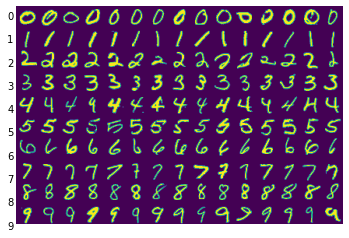

Train data shape:  (57000, 28, 28, 1)
Train labels shape:  (57000,)
Validation data shape:  (3000, 28, 28, 1)
Validation labels shape:  (3000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


In [4]:
data_dict, class_names = setup_data('MNIST', visualize=True, display=True)

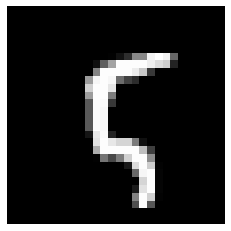

Class:  5   5


In [5]:
display_one_image(data_dict, class_names, 'train', 100)

In [18]:

limit_num_train = 100 

small_data = {
  'x_train': data_dict['x_train'][:limit_num_train],
  'y_train': data_dict['y_train'][:limit_num_train],
  'x_val': data_dict['x_val'],
  'y_val': data_dict['y_val']
}

In [19]:
training_data_dictionary = {limit :
    {
      'x_train': data_dict['x_train'][:limit_num_train],
      'y_train': data_dict['y_train'][:limit_num_train],
      'x_val': data_dict['x_val'],
      'y_val': data_dict['y_val']
    } for limit in [1000,2000,5000]}

In [20]:
print (training_data_dictionary.keys())

dict_keys([1000, 2000, 5000])


Train: X=(57000, 28, 28, 1), y=(57000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


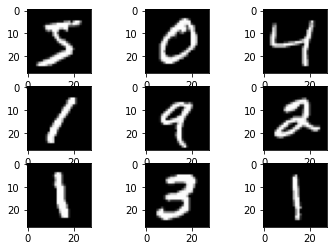

In [6]:
# View data
# summarize loaded dataset
print('Train: X=%s, y=%s' % (data_dict['x_train'].shape, data_dict['y_train'].shape))
print('Test: X=%s, y=%s' % (data_dict['x_test'].shape, data_dict['y_test'].shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(data_dict['x_train'][i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [7]:
input_shape=(28, 28, 1)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation="softmax"),
    ]
)
model.summary()

# Another way to define the same model, is to "add" layers one at a time

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model
              
#model = define_model()
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [8]:
from keras.utils import to_categorical
num_classes = 10
cat_y_train = to_categorical(data_dict['y_train'], num_classes)#converted the y train and test to categorical since when doing the model fit if I didn't do this it would give an error
cat_y_test = to_categorical(data_dict['y_test'], num_classes)

In [9]:
## Train the model
# training the model using the x_train and cat_y_train from above
batch_size = 128
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history=model.fit(data_dict['x_train'], cat_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/10
401/401 [==============================] - 4s 9ms/step - loss: 0.8714 - accuracy: 0.9087 - val_loss: 0.0936 - val_accuracy: 0.9707
Epoch 2/10
401/401 [==============================] - 4s 9ms/step - loss: 0.0792 - accuracy: 0.9761 - val_loss: 0.0763 - val_accuracy: 0.9784
Epoch 3/10
401/401 [==============================] - 4s 9ms/step - loss: 0.0506 - accuracy: 0.9842 - val_loss: 0.0774 - val_accuracy: 0.9770
Epoch 4/10
401/401 [==============================] - 4s 9ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0669 - val_accuracy: 0.9818
Epoch 5/10
401/401 [==============================] - 4s 9ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0640 - val_accuracy: 0.9828
Epoch 6/10
401/401 [==============================] - 3s 9ms/step - loss: 0.0239 - accuracy: 0.9919 - val_loss: 0.0772 - val_accuracy: 0.9804
Epoch 7/10
401/401 [==============================] - 4s 9ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.0602 - val_accuracy: 0.9868
Epoch 

In [10]:
model.save('basemodel_MNIST.h5') #saved my model to use later

In [11]:
score = model.evaluate(data_dict['x_test'], cat_y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05890125036239624
Test accuracy: 0.9871000051498413


In [12]:
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.xlabel('Training Epochs')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.tight_layout(pad=2)
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.xlabel('Training Epochs')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

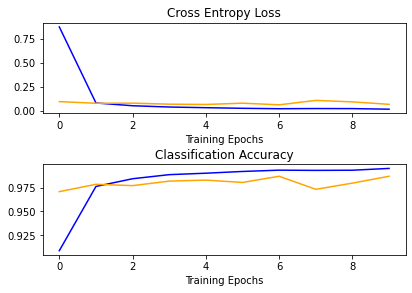

In [13]:
summarize_diagnostics([history])

In [14]:
results = model.predict(data_dict['x_test'],verbose=0)

In [15]:
predict_results = model.predict_classes(data_dict['x_test'])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [16]:
for index in range(20):
    print (predict_results[index], data_dict['y_test'][index])

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9
0 0
6 6
9 9
0 0
1 1
5 5
9 9
7 7
3 3
4 4


In [34]:
numb_img = (data_dict['x_train'].shape)
ten = (numb_img[0])/10
#started by taking the shape of the data dict to get the size of it then divided it in order to start with the 10 percent first

(57000, 28, 28, 1)
57000
5700.0


In [35]:
train_pct_index = int(ten)

In [41]:
ten_x = data_dict['x_train'][:train_pct_index]
ten_y = cat_y_train[:train_pct_index] # limited the train set to only ten percent to make sure the methodolgy worked before moving on

In [42]:
historyten=model.fit(ten_x, ten_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/10
41/41 [==============================] - 1s 15ms/step - loss: 0.1978 - accuracy: 0.9717 - val_loss: 0.0657 - val_accuracy: 0.9842
Epoch 2/10
41/41 [==============================] - 1s 13ms/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.0619 - val_accuracy: 0.9877
Epoch 3/10
41/41 [==============================] - 1s 13ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0422 - val_accuracy: 0.9930
Epoch 4/10
41/41 [==============================] - 1s 14ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0401 - val_accuracy: 0.9912
Epoch 5/10
41/41 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9912
Epoch 6/10
41/41 [==============================] - 1s 13ms/step - loss: 5.8088e-04 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9912
Epoch 7/10
41/41 [==============================] - 1s 13ms/step - loss: 4.0518e-04 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.9912
Epoch

In [89]:
a = np.arange(start=.1, stop=1, step=.1)
count = np.arange(9)
rando=numb_img[0]*a[8]
#created the necessary arrays in order to incriment by 10 percent

0.9
0
0.9
1
0.9
2
0.9
3
0.9
4
0.9
5
0.9
6
0.9
7
0.9
8


In [111]:
x = a * numb_img[0] # creating an array with the incrimented percentage
w = x.astype(int)
print(w)

[ 5700 11400 17100 22800 28500 34200 39900 45600 51300]


In [116]:
training_data_dictionary = {limit :
    {
      'x_train': data_dict['x_train'][:limit],
      'y_train': cat_y_train[:limit],
      'x_val': data_dict['x_val'],
      'y_val': data_dict['y_val']
    } for limit in w} # now limiting the training set to the percentages and storing it all in the profs favorite thing in the world

In [117]:
print (training_data_dictionary.keys()) # print the keys to make sure it worked

dict_keys([5700, 11400, 17100, 22800, 28500, 34200, 39900, 45600, 51300])


In [123]:
historyten=model.fit(training_data_dictionary[51300]['x_train'],training_data_dictionary[51300]['y_train'], batch_size=batch_size, epochs=epochs, validation_split=0.1)
#tested it out again for 10 percent to compare with above before doing it all

Epoch 1/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0384 - accuracy: 0.9902 - val_loss: 0.0217 - val_accuracy: 0.9928
Epoch 2/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.0235 - val_accuracy: 0.9942
Epoch 3/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0122 - val_accuracy: 0.9971
Epoch 4/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0289 - val_accuracy: 0.9914
Epoch 5/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0172 - val_accuracy: 0.9942
Epoch 6/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0166 - val_accuracy: 0.9945
Epoch 7/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0361 - val_accuracy: 0.9930
Epoch 

In [149]:
please_work = {} #technically the end user can't see our variable names and desperation right...right?
score_dict = {}
for r in w:
    historypercent=model.fit(training_data_dictionary[r]['x_train'],training_data_dictionary[r]['y_train'], batch_size=batch_size, epochs=epochs, validation_split=0.1)
    please_work[r] = historypercent
    score_dict[r] = model.evaluate(data_dict['x_test'], cat_y_test, verbose=0)

Epoch 1/10
41/41 [==============================] - 1s 14ms/step - loss: 2.3606e-06 - accuracy: 1.0000 - val_loss: 2.3095e-04 - val_accuracy: 1.0000
Epoch 2/10
41/41 [==============================] - 1s 13ms/step - loss: 2.2482e-06 - accuracy: 1.0000 - val_loss: 2.2884e-04 - val_accuracy: 1.0000
Epoch 3/10
41/41 [==============================] - 1s 13ms/step - loss: 2.1522e-06 - accuracy: 1.0000 - val_loss: 2.2695e-04 - val_accuracy: 1.0000
Epoch 4/10
41/41 [==============================] - 1s 13ms/step - loss: 2.0666e-06 - accuracy: 1.0000 - val_loss: 2.2554e-04 - val_accuracy: 1.0000
Epoch 5/10
41/41 [==============================] - 1s 13ms/step - loss: 1.9840e-06 - accuracy: 1.0000 - val_loss: 2.2363e-04 - val_accuracy: 1.0000
Epoch 6/10
41/41 [==============================] - 1s 13ms/step - loss: 1.9105e-06 - accuracy: 1.0000 - val_loss: 2.2248e-04 - val_accuracy: 1.0000
Epoch 7/10
41/41 [==============================] - 1s 13ms/step - loss: 1.8432e-06 - accuracy: 1.0000 - v

In [150]:
#print the keys make sure it is lined up
print(please_work.keys())
print(score_dict.keys())

dict_keys([5700, 11400, 17100, 22800, 28500, 34200, 39900, 45600, 51300])
dict_keys([5700, 11400, 17100, 22800, 28500, 34200, 39900, 45600, 51300])


5700


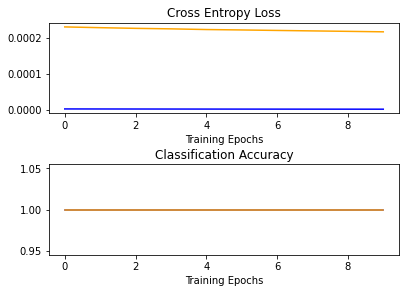

Test loss: 0.15957972407341003
Test accuracy: 0.9868000149726868
11400


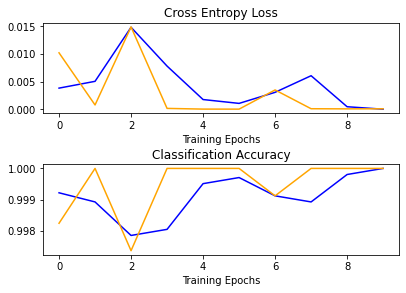

Test loss: 0.18204741179943085
Test accuracy: 0.9847000241279602
17100


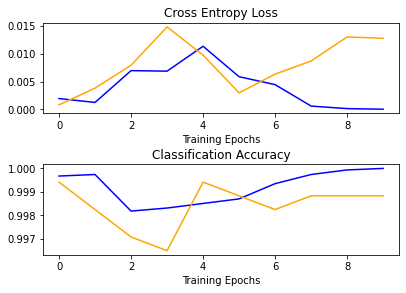

Test loss: 0.1900220513343811
Test accuracy: 0.9865000247955322
22800


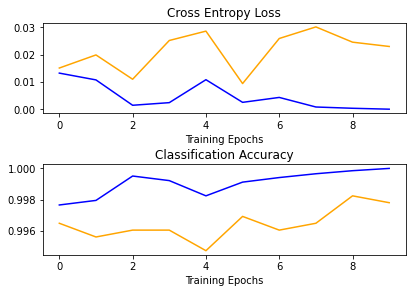

Test loss: 0.23581233620643616
Test accuracy: 0.9857000112533569
28500


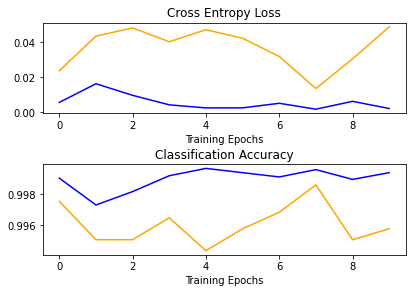

Test loss: 0.27459922432899475
Test accuracy: 0.9839000105857849
34200


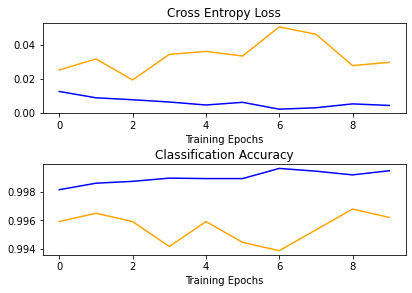

Test loss: 0.2372155785560608
Test accuracy: 0.9854000210762024
39900


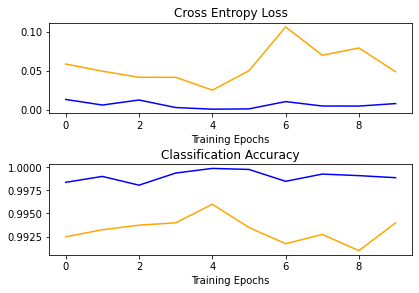

Test loss: 0.253671795129776
Test accuracy: 0.9851999878883362
45600


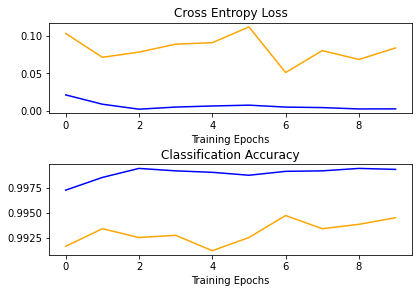

Test loss: 0.29749995470046997
Test accuracy: 0.9846000075340271
51300


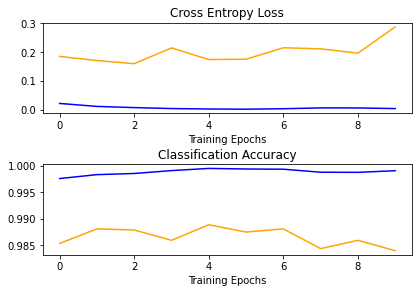

Test loss: 0.3075658977031708
Test accuracy: 0.9843000173568726


In [151]:
for r in w:
    print (r)
    summarize_diagnostics([please_work[r]])
    print("Test loss:", score_dict[r][0])
    print("Test accuracy:", score_dict[r][1])
    #now create the graphs for each one and evaluate

In [147]:
score = model.evaluate(data_dict['x_test'], cat_y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1643347293138504
Test accuracy: 0.9861999750137329


In [177]:
test_model = load_model('basemodel_MNIST.h5')#reload the test model

In [192]:
def smallVgg(howmany): #created a smallvgg with the option to limit how many times it is added
    test_model = Sequential()
    test_model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding='same', activation='relu'))
    test_model.add(MaxPooling2D((3,3), strides=1))
    if (howmany == 'first'):
        test_model.add(Dense(256, activation='relu'))
        test_model.add(Dense(10, activation='softmax'))
        test_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return test_model
    test_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    test_model.add(MaxPooling2D((3,3), strides=1))
    if howmany == 'second':
        test_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return test_model
    test_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    test_model.add(MaxPooling2D((3,3), strides=1))
    if howmany == 'third':
        test_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return test_model
    test_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    test_model.add(MaxPooling2D((3,3), strides=1))
    if (howmany == 'fourth'):
        test_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return test_model
    test_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    test_model.add(MaxPooling2D((3,3), strides=1))
    test_model.add(Flatten())
    test_model.add(Dense(256, activation='relu'))
    test_model.add(Dense(10, activation='softmax'))
    test_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return test_model
how_many_time = 'all'
mod = smallVgg(how_many_time)#ran it through all adds
mod.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 22, 22, 128)     

In [180]:
historySmallVGG=mod.fit(data_dict['x_train'], cat_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/10
401/401 [==============================] - 84s 209ms/step - loss: 2.5069 - accuracy: 0.8958 - val_loss: 0.0886 - val_accuracy: 0.9721
Epoch 2/10
401/401 [==============================] - 75s 186ms/step - loss: 0.0733 - accuracy: 0.9769 - val_loss: 0.0637 - val_accuracy: 0.9796
Epoch 3/10
401/401 [==============================] - 84s 210ms/step - loss: 0.0555 - accuracy: 0.9832 - val_loss: 0.0451 - val_accuracy: 0.9861
Epoch 4/10
401/401 [==============================] - 95s 237ms/step - loss: 0.0425 - accuracy: 0.9864 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 5/10
401/401 [==============================] - 88s 219ms/step - loss: 0.0396 - accuracy: 0.9874 - val_loss: 0.0483 - val_accuracy: 0.9853
Epoch 6/10
401/401 [==============================] - 106s 264ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.0464 - val_accuracy: 0.9854
Epoch 7/10
401/401 [==============================] - 107s 266ms/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0.0914 - val_

In [181]:
scoreVGG = mod.evaluate(data_dict['x_test'], cat_y_test, verbose=0)
print("Test loss:", scoreVGG[0])
print("Test accuracy:", scoreVGG[1])#took the scores compared with base

Test loss: 0.03591165319085121
Test accuracy: 0.989300012588501


In [182]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1643347293138504
Test accuracy: 0.9861999750137329


In [183]:
def score_compare(scoreLoss1, scoreLoss2, accScore1, accScore2):
    avgLoss_score = (scoreLoss1 + scoreLoss2)/2
    avgAcc_score = (accScore1 + accScore2)/2
    pdiff_loss = (scoreLoss2 /scoreLoss1)*100
    pdiff_acc = (accScore2 / accScore1) *100
    return avgAcc_score, avgLoss_score, pdiff_acc, pdiff_loss#created a function to compare because it was much easier

In [184]:
print(score_compare(score[0], scoreVGG[0], score[1], scoreVGG[1]))

(0.9877499938011169, 0.10012319125235081, 100.31434168052225, 21.85274734123076)


In [193]:
how_many_time = 'first'
smallmod = smallVgg(how_many_time) # here is where you can control and see whether it is within 5 % or 1 % or what not
smallmod.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
dense_16 (Dense)             (None, 26, 26, 256)       8448      
_________________________________________________________________
dense_17 (Dense)             (None, 26, 26, 10)        2570      
Total params: 11,338
Trainable params: 11,338
Non-trainable params: 0
_________________________________________________________________


In [195]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [25]:
x_train_2d = data_dict['x_train'].reshape(data_dict['x_train'].shape[0], -1)

the_results = model.predict(data_dict['x_test'],verbose=0)
predict = model.predict_classes(data_dict['x_test']) # created the results and predict to be used in the confusion matric

In [39]:
import tensorflow as tf
from tensorflow import math
from tensorflow import dtypes

testing = data_dict['y_test']



In [81]:
for index in range(20):
    print (predict_results[index], data_dict['y_test'][index])
np.shape(predict)

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9
0 0
6 6
9 9
0 0
1 1
5 5
9 9
7 7
3 3
4 4


(10000,)

In [47]:
res = math.confusion_matrix(data_dict['y_test'], predict)#created the confusion matrix from tensorflow

In [86]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(data_dict['y_test'], predict, average='micro'))
print(recall_score(data_dict['y_test'], predict, average='micro'))# calculate the precision and recall scores

0.9871
0.9871


In [71]:
print('Confusion_matrix: ',res) 
print(np.max(res))#printed the confusion matrix

Confusion_matrix:  tf.Tensor(
[[ 975    1    1    1    0    1    0    1    0    0]
 [   0 1129    3    1    0    1    1    0    0    0]
 [   2    6 1016    3    0    0    1    4    0    0]
 [   0    0    1 1001    0    5    0    1    2    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   2    0    0    4    0  880    3    1    1    1]
 [   2    2    0    0    4    2  945    0    3    0]
 [   0    6    4    1    2    0    0 1011    2    2]
 [   2    0    4    7    1    2    1    1  954    2]
 [   1    4    1    3   10    3    0    6    0  981]], shape=(10, 10), dtype=int32)
1129


In [77]:
# then plotted the confusion matrix in a solid visual

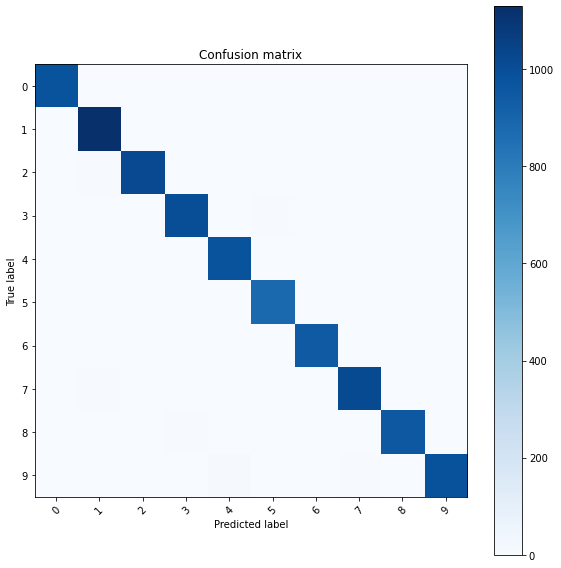

In [87]:
confusion = plot_confusion_matrix(res, class_names)